In [1]:
# Nash Cascade Neural Network
# A hydrologically intuitive deep learning network

# Set up a solution to a network of buckets where the number of buckets in each layer
# flows out to the buckets in the next layer
# The parameter on each bucket is the size and height of each spigot.

# Need a function that solves this individually at a single buckets
# Then a function that loops through and moves the water to the downstream buckets

In [2]:
import torch
import matplotlib.pyplot as plt
from ncnn import NashCascadeNeuralNetwork as ncnn
# Precipitation standard variable name used in the ncnn model interface
PRECIP_SVN = "atmosphere_water__liquid_equivalent_precipitation_rate"
DO_PLOT = True
N_TIMESTEPS = 500

In [3]:
network_precip_input_list = []
count = 0
for i in range(N_TIMESTEPS):

    ###########################################################################
    if count > 39:
        network_precip_input_list.append(1)
    else:
        network_precip_input_list.append(0)
    if count == 50:
        count = 0
    count+=1
    ###########################################################################


In [4]:
bucket_net = ncnn(cfg_file="./config_0.json")
bucket_net.initialize()

Initial Mass in network at start: 300.0
Final Mass in network: 9.6
Total Mass out of network 399.4
Total precipitation into network 109.0
Final mass balance is -0.000
Final mass balance is -0.000


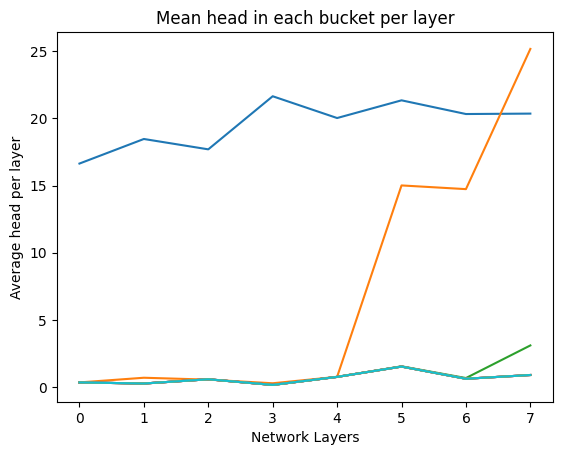

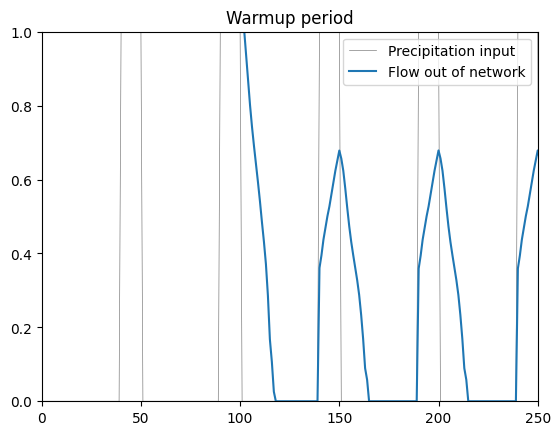

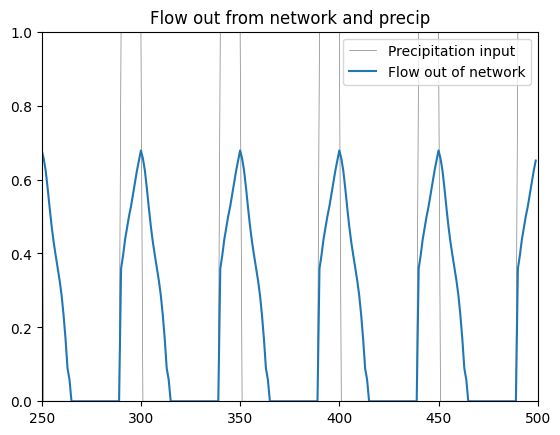

In [5]:
# Example 0
bucket_net = ncnn(cfg_file="./config_0.json")
bucket_net.initialize()
bucket_net.summarize_network()
inital_mass_in_network = torch.sum(torch.tensor([tensor.item() for tensor in bucket_net.sum_H_per_layer]))
print(f"Initial Mass in network at start: {inital_mass_in_network:.1f}")
network_outflow_list_0 = []
for i in range(N_TIMESTEPS):

    ###########################################################################
    ###########################################################################
    bucket_net.set_value(PRECIP_SVN, torch.tensor(network_precip_input_list[i]))
    bucket_net.update_network()
    network_outflow_list_0.append(bucket_net.network_outflow.item())
    bucket_net.summarize_network()
    ###########################################################################
    ###########################################################################

    if DO_PLOT:
        if i % int(N_TIMESTEPS/10) == 0:
            plt.plot([tensor.item() for tensor in bucket_net.mean_H_per_layer])

###########################################################################
# Assuming network_precip_input_list is a list of numbers
total_mass_precip_in = torch.sum(torch.tensor(network_precip_input_list))
# Assuming bucket_net.sum_H_per_layer is a list of PyTorch tensors
final_mass_in_network = torch.sum(torch.stack(bucket_net.sum_H_per_layer))
# Assuming network_outflow_list_0 is a list of numbers
total_mass_outflow = torch.sum(torch.tensor(network_outflow_list_0))
print(f"Final Mass in network: {final_mass_in_network:.1f}")
print(f"Total Mass out of network {total_mass_outflow:.1f}")
print(f"Total precipitation into network {total_mass_precip_in:.1f}")
mass_balance = (inital_mass_in_network + total_mass_precip_in) - (final_mass_in_network + total_mass_outflow)
print(f"Final mass balance is {mass_balance:.3f}")
mass_balance = (inital_mass_in_network - final_mass_in_network) - (total_mass_outflow - total_mass_precip_in)
print(f"Final mass balance is {mass_balance:.3f}")
if DO_PLOT:
    plt.title("Mean head in each bucket per layer")
    plt.ylabel("Average head per layer")
    plt.xlabel("Network Layers")
    plt.show()
    plt.close()

if DO_PLOT:
    startplt = 0
    endplt = 250

    plt.plot(network_precip_input_list, c="grey", lw=0.5, label="Precipitation input")
    plt.plot(network_outflow_list_0, label="Flow out of network")
    plt.xlim([startplt, endplt])
    plt.ylim([0, torch.max(torch.tensor(network_precip_input_list[startplt:endplt])).item()])
    plt.legend()
    plt.title("Warmup period")
    plt.show()
    plt.close()
    startplt = int(len(network_outflow_list_0)-(len(network_outflow_list_0)/2))
    endplt = int(len(network_outflow_list_0))
    plt.plot(network_precip_input_list, c="grey", lw=0.5, label="Precipitation input")
    plt.plot(network_outflow_list_0, label="Flow out of network")
    plt.xlim([startplt, endplt])
    plt.ylim([0, torch.max(torch.tensor(network_precip_input_list[startplt:endplt])).item()])
    plt.legend()
    plt.title("Flow out from network and precip")
    plt.show()
    plt.close()

Initial Mass in network at start: 300.0
Final Mass in network: 8.7
Total Mass out of network 400.3
Total precipitation into network 109.0
Final mass balance is -0.000
Final mass balance is -0.000


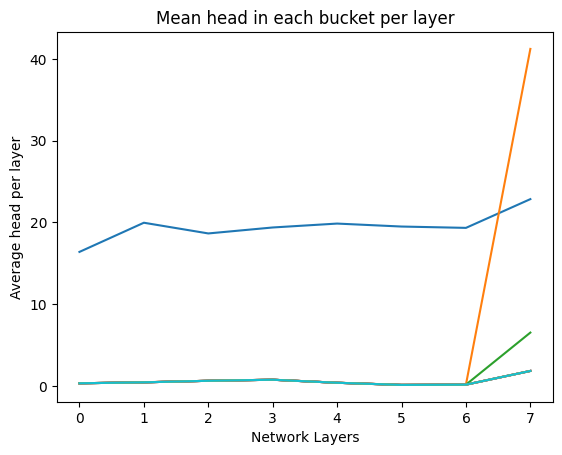

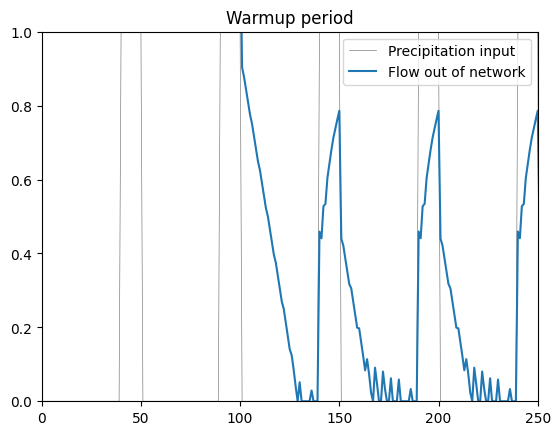

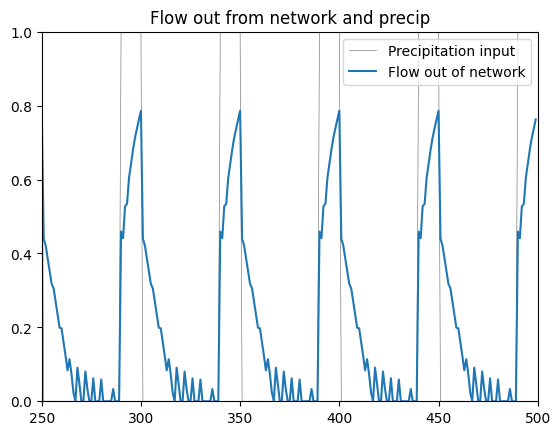

In [6]:
# Example 1
bucket_net = ncnn(cfg_file="./config_1.json")
bucket_net.initialize()
bucket_net.summarize_network()
inital_mass_in_network = torch.sum(torch.stack(bucket_net.sum_H_per_layer)).item()
print(f"Initial Mass in network at start: {inital_mass_in_network:.1f}")
network_outflow_list_1 = []
for i in range(N_TIMESTEPS):

    ###########################################################################
    ###########################################################################
    bucket_net.set_value(PRECIP_SVN, torch.tensor(network_precip_input_list[i]))
    bucket_net.update_network()
    network_outflow_list_1.append(bucket_net.network_outflow.item())
    bucket_net.summarize_network()
    ###########################################################################
    ###########################################################################

    if DO_PLOT:
        if i % int(N_TIMESTEPS/10) == 0:
            plt.plot([tensor.item() for tensor in bucket_net.mean_H_per_layer])

###########################################################################
total_mass_precip_in = torch.sum(torch.tensor(network_precip_input_list)).item()
final_mass_in_network = torch.sum(torch.stack(bucket_net.sum_H_per_layer)).item()
total_mass_outflow = torch.sum(torch.tensor(network_outflow_list_1)).item()
print(f"Final Mass in network: {final_mass_in_network:.1f}")
print(f"Total Mass out of network {total_mass_outflow:.1f}")
print(f"Total precipitation into network {total_mass_precip_in:.1f}")
mass_balance = (inital_mass_in_network + total_mass_precip_in) - (final_mass_in_network + total_mass_outflow)
print(f"Final mass balance is {mass_balance:.3f}")
mass_balance = (inital_mass_in_network - final_mass_in_network) - (total_mass_outflow - total_mass_precip_in)
print(f"Final mass balance is {mass_balance:.3f}")
if DO_PLOT:
    plt.title("Mean head in each bucket per layer")
    plt.ylabel("Average head per layer")
    plt.xlabel("Network Layers")
    plt.show()
    plt.close()

if DO_PLOT:
    startplt = 0
    endplt = 250

    plt.plot(network_precip_input_list, c="grey", lw=0.5, label="Precipitation input")
    plt.plot(network_outflow_list_1, label="Flow out of network")
    plt.xlim([startplt, endplt])
    plt.ylim([0, torch.max(torch.tensor(network_precip_input_list)[startplt:endplt]).item()])
    plt.legend()
    plt.title("Warmup period")
    plt.show()
    plt.close()
    startplt = int(len(network_outflow_list_1)-(len(network_outflow_list_1)/2))
    endplt = int(len(network_outflow_list_1))
    plt.plot(network_precip_input_list, c="grey", lw=0.5, label="Precipitation input")
    plt.plot(network_outflow_list_1, label="Flow out of network")
    plt.xlim([startplt, endplt])
    plt.ylim([0, torch.max(torch.tensor(network_precip_input_list)[startplt:endplt]).item()])
    plt.legend()
    plt.title("Flow out from network and precip")
    plt.show()
    plt.close()

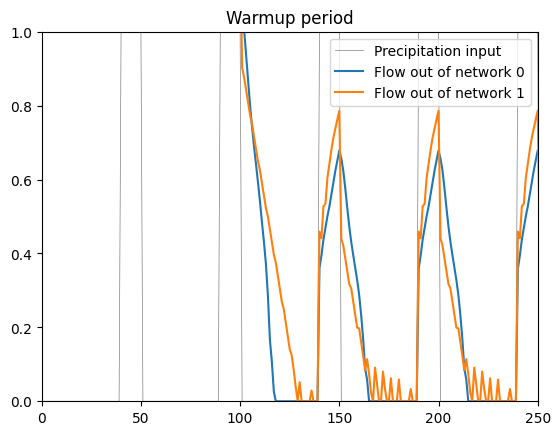

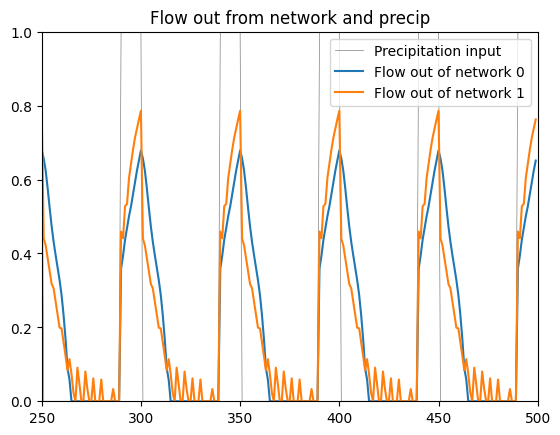

In [7]:
if DO_PLOT:
    startplt = 0
    endplt = 250

    plt.plot(network_precip_input_list, c="grey", lw=0.5, label="Precipitation input")
    plt.plot(network_outflow_list_0, label="Flow out of network 0")
    plt.plot(network_outflow_list_1, label="Flow out of network 1")
    plt.xlim([startplt, endplt])
    tensor_version = torch.tensor(network_precip_input_list)
    max_val = torch.max(tensor_version[startplt:endplt]).item()
    plt.ylim([0, max_val])
    plt.legend()
    plt.title("Warmup period")
    plt.show()
    plt.close()
    startplt = int(len(network_outflow_list_1)-(len(network_outflow_list_1)/2))
    endplt = int(len(network_outflow_list_1))
    plt.plot(network_precip_input_list, c="grey", lw=0.5, label="Precipitation input")
    plt.plot(network_outflow_list_0, label="Flow out of network 0")
    plt.plot(network_outflow_list_1, label="Flow out of network 1")
    plt.xlim([startplt, endplt])
    network_precip_tensor = torch.tensor(network_precip_input_list)
    max_value = torch.max(network_precip_tensor[startplt:endplt]).item()
    plt.ylim([0, max_value])
    plt.legend()
    plt.title("Flow out from network and precip")
    plt.show()
    plt.close()

In [8]:
bucket_net.train_theta_values(network_precip_input_list, network_outflow_list_0)

network_outflow_list_1 = bucket_net.y_pred

print(bucket_net.theta.grad)

loss is: 0.1612689346075058, theta[0][0][0] is: 0.17612126469612122
Initial Mass in network at start: 300.0
Final Mass in network: 8.7
Total Mass out of network 400.3
Total precipitation into network 109.0
Final mass balance is -0.000
Final mass balance is -0.000
loss is: 0.1612689346075058, theta[0][0][0] is: 0.17612126469612122
Initial Mass in network at start: 300.0
Final Mass in network: 8.7
Total Mass out of network 400.3
Total precipitation into network 109.0
Final mass balance is -0.000
Final mass balance is -0.000
None


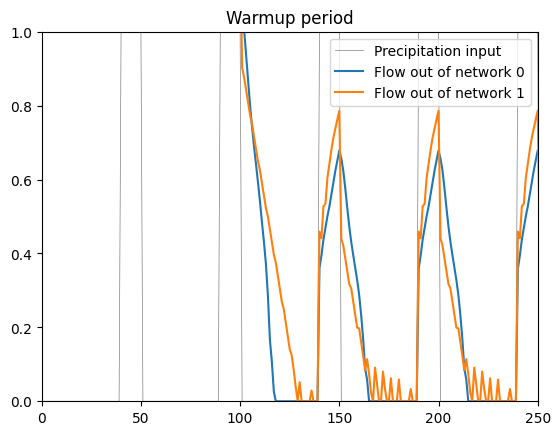

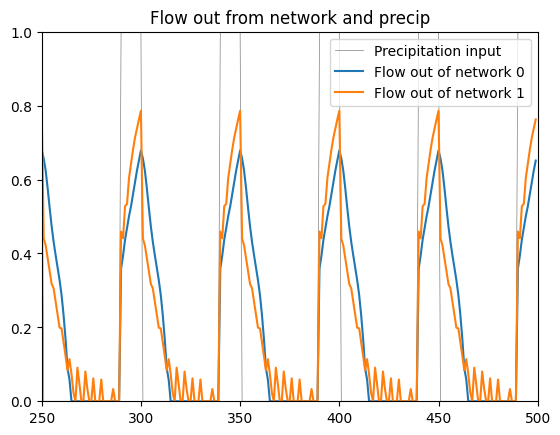

In [9]:
if DO_PLOT:

    startplt = 0
    endplt = 250

    plt.plot(network_precip_input_list, c="grey", lw=0.5, label="Precipitation input")
    plt.plot(network_outflow_list_0, label="Flow out of network 0")
    plt.plot(network_outflow_list_1, label="Flow out of network 1")
    plt.xlim([startplt, endplt])
    network_precip_tensor = torch.tensor(network_precip_input_list)
    max_value = torch.max(network_precip_tensor[startplt:endplt]).item()
    plt.ylim([0, max_value])
    plt.legend()
    plt.title("Warmup period")
    plt.show()
    plt.close()
    startplt = int(len(network_outflow_list_1)-(len(network_outflow_list_1)/2))
    endplt = int(len(network_outflow_list_1))
    plt.plot(network_precip_input_list, c="grey", lw=0.5, label="Precipitation input")
    plt.plot(network_outflow_list_0, label="Flow out of network 0")
    plt.plot(network_outflow_list_1, label="Flow out of network 1")
    plt.xlim([startplt, endplt])
    network_precip_tensor = torch.tensor(network_precip_input_list)
    max_value = torch.max(network_precip_tensor[startplt:endplt]).item()
    plt.ylim([0, max_value])
    plt.legend()
    plt.title("Flow out from network and precip")
    plt.show()
    plt.close()

In [10]:
!pip install torchviz

Defaulting to user installation because normal site-packages is not writeable


In [11]:
from torchviz import make_dot

make_dot(bucket_net.loss).view()

'Digraph.gv.pdf'

/usr/bin/xdg-open: 882: www-browser: not found
/usr/bin/xdg-open: 882: links2: not found
/usr/bin/xdg-open: 882: elinks: not found
/usr/bin/xdg-open: 882: links: not found
/usr/bin/xdg-open: 882: lynx: not found
/usr/bin/xdg-open: 882: w3m: not found
xdg-open: no method available for opening 'Digraph.gv.pdf'
